# 루브릭
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
    - 기획한 서비스가 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?
    - 앞서 기획한 서비스에서 OCR모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.
3. 평가 기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
    - 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import os
import io
import cv2 

from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


## 데이터셋 가져오기

In [2]:
file_path = os.getenv('HOME')+'/aiffel/ocr_python/data/'
os.listdir(file_path)

['20.png',
 '16.png',
 '5.png',
 '2.png',
 '12.png',
 '10.png',
 '14.png',
 '1.png',
 '15.png',
 '11.png',
 '7.png',
 '18.png',
 '3.png',
 '8.png',
 '17.png',
 '4.png',
 '6.png',
 '19.png',
 '9.png',
 '13.png']

In [3]:
images_path = glob(file_path+'*.png')
images_path

['/aiffel/aiffel/ocr_python/data/20.png',
 '/aiffel/aiffel/ocr_python/data/16.png',
 '/aiffel/aiffel/ocr_python/data/5.png',
 '/aiffel/aiffel/ocr_python/data/2.png',
 '/aiffel/aiffel/ocr_python/data/12.png',
 '/aiffel/aiffel/ocr_python/data/10.png',
 '/aiffel/aiffel/ocr_python/data/14.png',
 '/aiffel/aiffel/ocr_python/data/1.png',
 '/aiffel/aiffel/ocr_python/data/15.png',
 '/aiffel/aiffel/ocr_python/data/11.png',
 '/aiffel/aiffel/ocr_python/data/7.png',
 '/aiffel/aiffel/ocr_python/data/18.png',
 '/aiffel/aiffel/ocr_python/data/3.png',
 '/aiffel/aiffel/ocr_python/data/8.png',
 '/aiffel/aiffel/ocr_python/data/17.png',
 '/aiffel/aiffel/ocr_python/data/4.png',
 '/aiffel/aiffel/ocr_python/data/6.png',
 '/aiffel/aiffel/ocr_python/data/19.png',
 '/aiffel/aiffel/ocr_python/data/9.png',
 '/aiffel/aiffel/ocr_python/data/13.png']

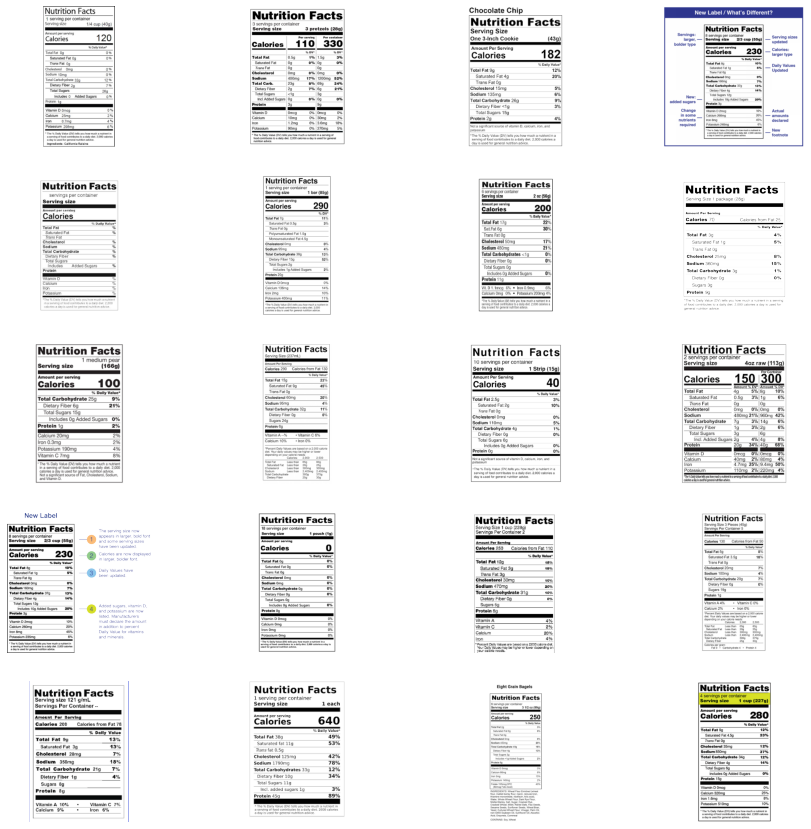

In [4]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path):
    plt.subplot(5, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

위의 Image들은 어떤 제품들의 성분표 입니다. 성분표 분석을 하기 위해 ocr을 이용해 성분을 불러오는 것이 목표 입니다.
ocr을 활용해 잘 검출되는지 확인해보겠습니다.

## keras-ocr

In [5]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
images = [ keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

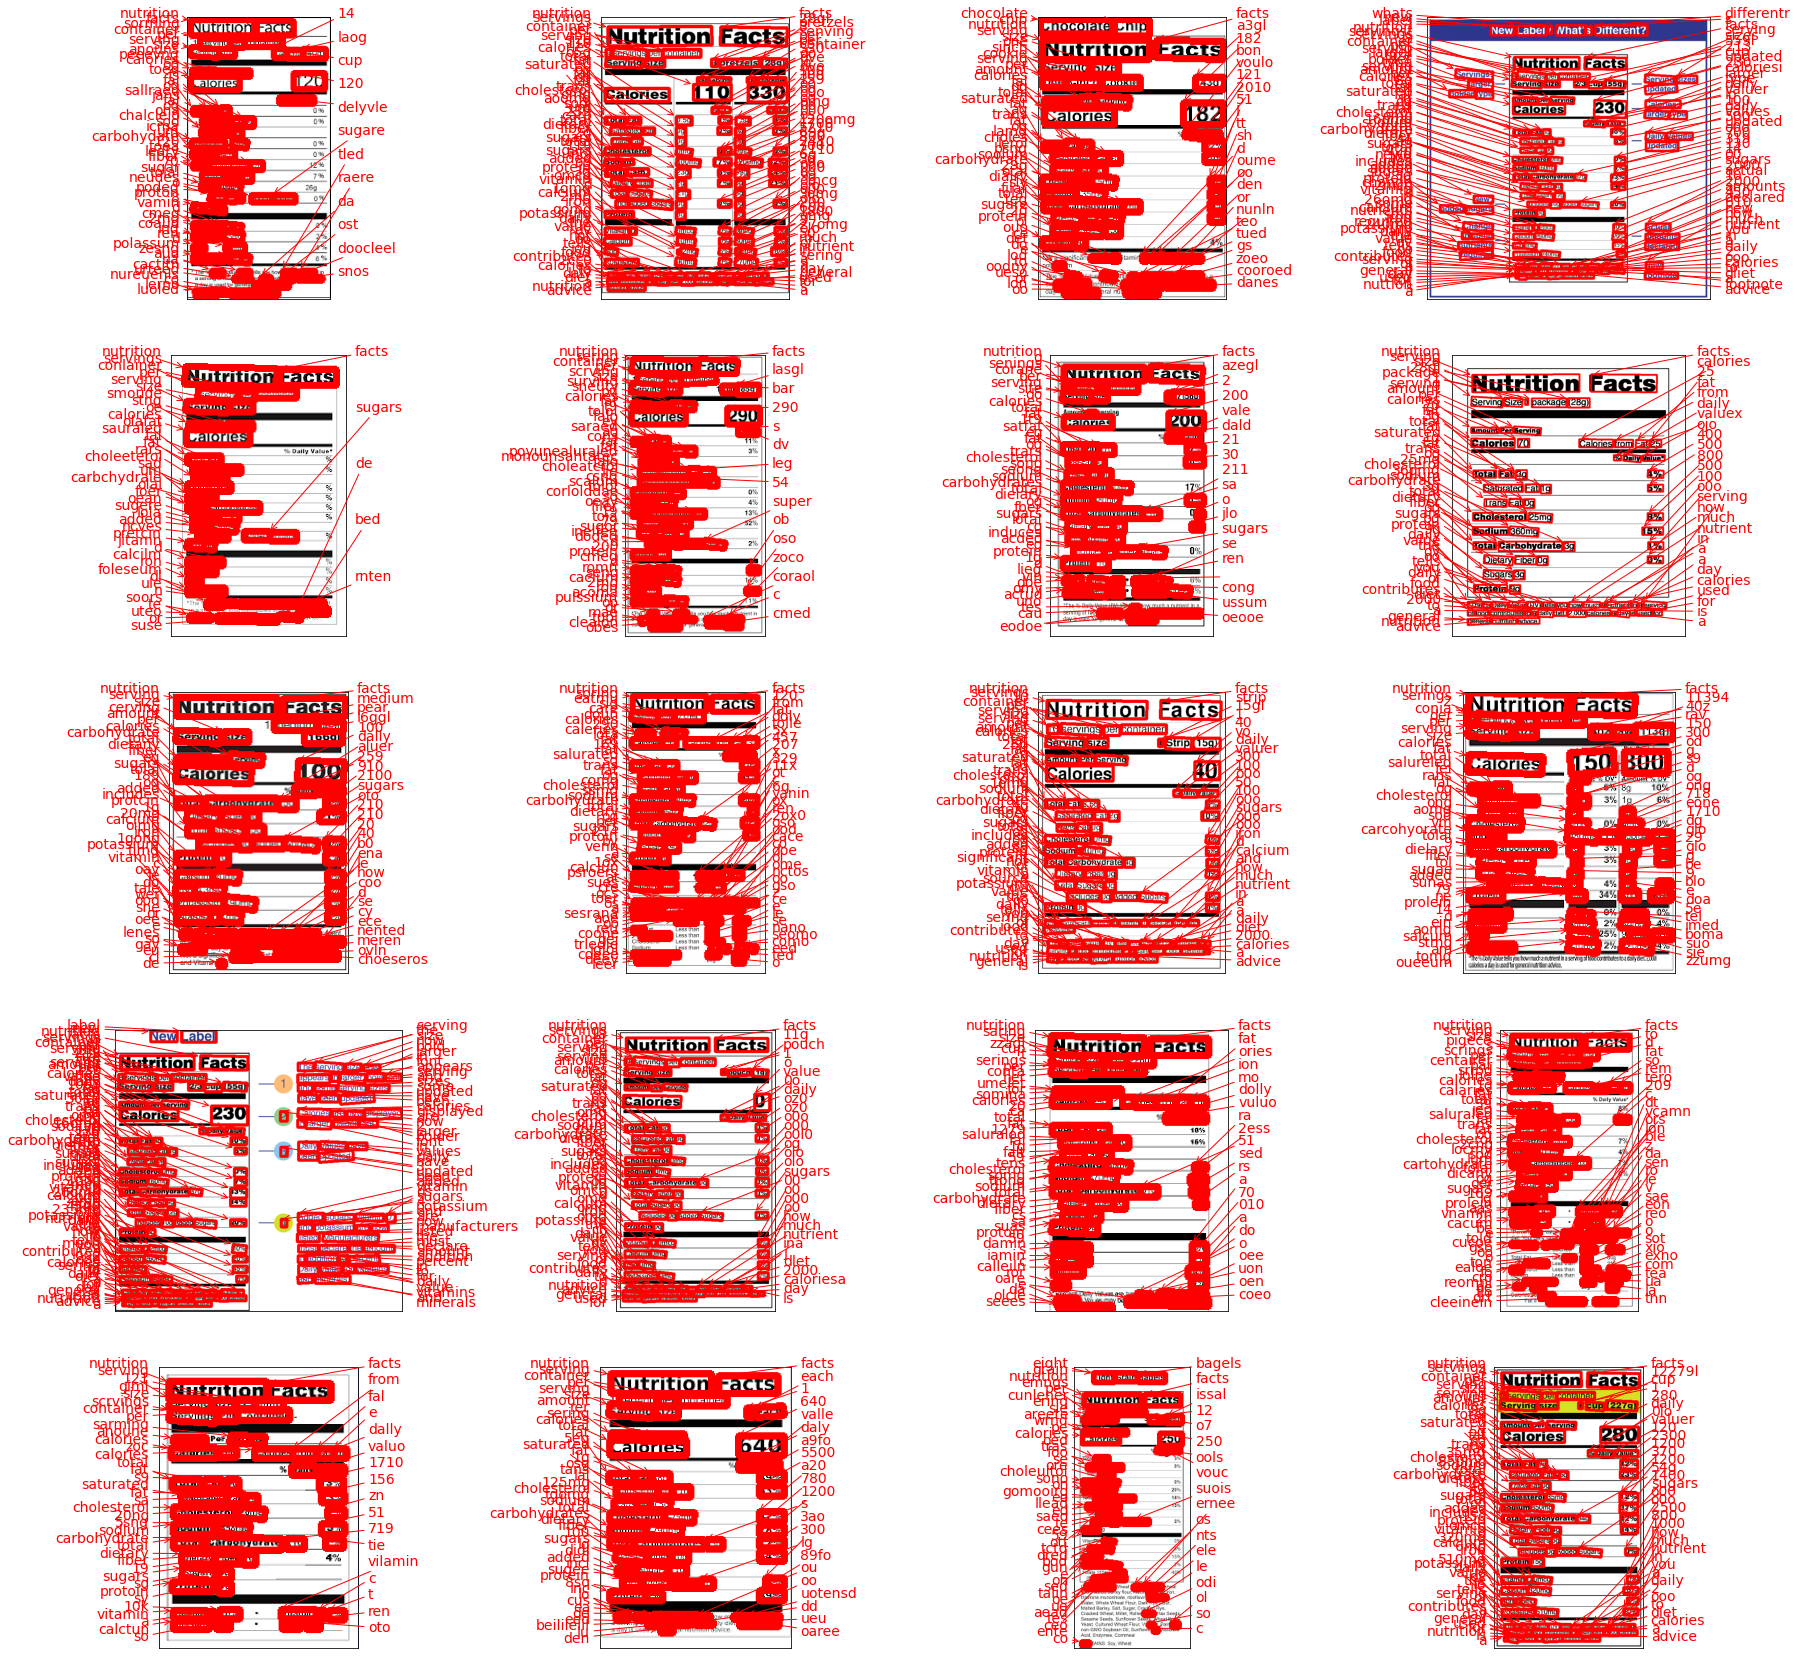

In [7]:
fig, axs = plt.subplots(5, 4, figsize=(30, 30))

for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[4*a+b], 
                                    predictions=predictions[4*a+b][0], ax=axs[a,b])

keras-ocr은 Tensorflow의 Keras API를 기반으로 이미지 속 문자를 읽은 End-to-End OCR을 할 수 있게 해줍니다. 검출 모델로는 CRAFT를 사용하고, 인식 모델로는 CRNN을 사용합니다.

검출 결과는 보이듯이 잘 검출 해주고 있음을 알 수 있습니다. 하지만 자세히 보면 숫자 표기의 소수점이 표시가 되지 않음을 알 수 있습니다.

## Tesseract

In [8]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/output/' 

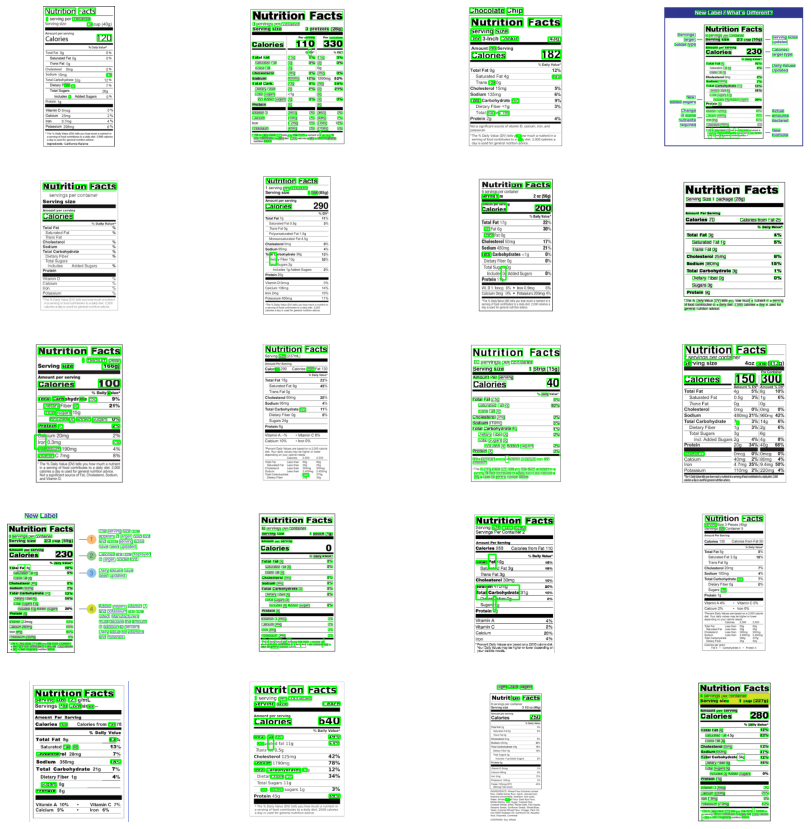

In [9]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 15))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

In [10]:
def recognize_images(cropped_image_path_list):
    test = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pt.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        test.append(recognized_data['text'].replace('\n', '').replace('\x0c',''))
        
    print(test)
    print("Done")

## 텍스트 정확도 비교하기

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

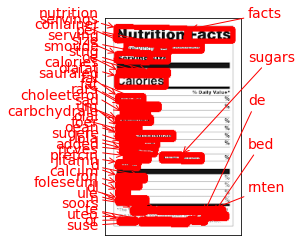

In [12]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[4], 
                                    predictions=predictions[4][0])
print(a)

['Nutr', 'rr}', 'Facts', 'Serving', 're 8 bl pee ee', ':', 'Pipe', '0 |', 'Servings', 'pod te', 'Loorviairwer *', 'wit rer ss', 'Laores', '130', 'reas from', 'Total Fat og', 'ss sete proet peed', 'pat Jog', '1B %', 'Tarts', 'Pat Ug', 'Lholesterol', 'eurng', 'SOc any', 'lWUMmg', '4.', 'Total &', 'bonydrate', 'éUY', 'retary', 'YP er', '', 'Sugars', 'Sg', 'Vrobery', "'g", 'Vrarmin A 4%', 'Veamm © O%', 'au', 'fon', '| Tes', '"Our Cay Vea', 'wy iw', 'f ime Teer OF Power', 'we', 'sep', '', 'a a? fa', 'se', 'ht', 'oe Tur', '“9', '-s', '', 'ae', '=', 'ee er aa ae', 'Te', 'oe Tur', 'aang', 'GID', '‘e+', 'aie Dae', '', 'In', 'Le TET eS ae «', '']
Done


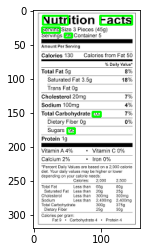

In [15]:
plt.imshow(img_dict['4'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['4'])

ocr을 이용해 성분표 분석을 하게 되었을 때를 생각하여, 다음과 같은 상황을 진행해보았습니다.
- keras-ocr을 이용했을 때, 꽤나 검출이 잘 되는 것을 볼 수 있습니다. 하지만 숫자에서 소수점 인식을 못한다는 단점을 보여주고 있습니다.
- tesseract를 이용했을 때에는 검출이 거의 원할하게 진행되지 않는 것을 볼 수 있습니다. 글자가 작아서 인지 원활하게 되지 않습니다.
google-API는 인증을 받고 하는 과정으로 인해 진행하지 않았지만, 결과가 좋지 않음을 보아 실험을 진행해 비교하는 과정이 필요할 것으로 보입니다.